This code comes mostly from this Q-learning educational video: 
https://www.youtube.com/watch?v=nSxaG_Kjw_w

In [2]:
import numpy as np
import pylab as plt
import networkx as nx

In [3]:
#state transition capababilities
#state-action pairs

edges_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7),  
              (8,3), (8,5), (8,4), (9,4), (9,8), (9,3), (9,6),
              (1,8), (1,3), (0,4), (0,6), (10,8), (10,2), (10,6),
              (2,11), (2,12), (2,13), (2,14), (13,14), (13,12),
              (2,15), (2,16), (2,17), (2,18), (2,19), (2,20)]

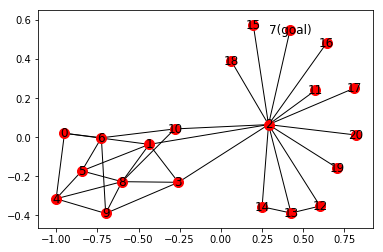

In [4]:
#visualize the connections

G = nx.Graph()
G.add_edges_from(edges_list)
mapping={7:'7(goal)'}
H=nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(H)
nx.draw_networkx_nodes(H, pos, node_size=[100])
nx.draw_networkx_edges(H, pos)
nx.draw_networkx_labels(H, pos)
plt.show()

In [5]:
#Define the reward matrix R
#This will allow our agent to learn how to navigate this network to reach the goal, state 7

#R shows the reward you give your agent for taking an action a from state s (hidden from the agent) 
#In this case the agent's action a is just a choice to move to a new state s'
#The desired end state, state 7, has a reward

goal = 7 

#state transition reward matrix size (state numbered 0-20)
#Q matrix size
matrix_size = 21

#Fill in the reward matrix for state-action pairs

#Initialize Rewards Matrix
R = np.ones((matrix_size, matrix_size))
R = R*-1 #since our actions will take a max over transition possibilities, the -1s act as out-of-bounds

for path in edges_list: #a path is a state-action transition pair
    if path[1] == goal: #if the end state/node in the state-action or state-new_state pair is the goal
        R[path] = 100 #the reward for the action of moving from state i to state j (the goal) is 100
    else:
        R[path] = 0 #all other state-action pairs get no reward
        
    #going in the opposite direction
    #we assume that if you can go from state i to state j, you can also go from state j to state i
    #this specific to this example, and is not in general the case
    if path[0] == goal: #if the beginning state i is the goal
        R[(path[1], path[0])] = 100 #the action of moving from state j to state i is 100
    else:
        R[(path[1], path[0])] = 0 #all other reverse action/paths get no reward
        

#allow for the possibility to stay in the final goal state
#the value of being in the goal state will move to a perpetuity value of Reward/(1-discount factor)
#not important to allow the agent to stay in other states since it just wastes exploration time
R[goal,goal] = 100

In [6]:
#Define what your agent can do
#Your agent will explore the state-action space, updating Q-values, which are explained below

#survey possible actions
def available_actions(state):
    current_state_row = R[state,]
    #negative numbers are used to define states that are not accessible
    av_act = np.where(current_state_row >= 0)[0] #tutorial has index 1 but maybe that's because Reward matrix R is wrapped in matrix?
    return av_act

#randomly choose a possible action
def sample_next_action(available_act): 
    next_action = int(np.random.choice(available_act,1)) #maybe should have ,1 to make it an array?
    return next_action

In [8]:
#There is a Q-value Matrix Q that will be created in training 
#A Q-value represents the current estimate of the present value of future rewards for a state-action pair
#Based on the latest action and reward feedback, your agent updates its assesment of the value of moving from state s to state s'
#The Q Values below represent the Present Value of Expected Future Reward 
#This update happens at time 1 (after the action and reward), but is a PV estimate from time 0 (before action and reward)
def update(current_state, action, discount_factor):
    
    #now look ahead given that you're in the next state. take note of which action you think has the highest payoff
    max_index = np.where(Q[action,] == np.max(Q[action,]))[0]  #tutorial has index 1 but maybe that's because R is wrapped in matrix?
    
    if max_index.shape[0] > 1: #if two actions seem to be equally good in terms of future payoffs
        max_index = int(np.random.choice(max_index, size = 1)) #randomly choose one (it won't matter because they're equal in assessment)
    else:
        max_index = int(max_index) 
        
    expected_remaining_present_value = Q[action, max_index] #current assesment of the PV of future expected returns going forward from t=1

    #There is an implicit weighting of 1 here since we don't blend the old Q-value estimate in with a learning rate
    #We could weight our old Q-Value estimate with our new Q-value estimate, but we don't here
    Q[current_state, action] = R[current_state, action] + discount_factor*expected_remaining_present_value #Bellman Equation
    print('An updated assessment of being in state', current_state, 'and taking action to go to state ', action,' is: ', Q[current_state, action])
    
    return(np.sum(Q)) #jdk's score metric, just to see if our Q-matrix has converged (i.e. stopped updating Q-values)

In [9]:
#see Reward Matrix
print(R)

[[ -1.   0.  -1.  -1.   0.  -1.   0.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.   0.   0.  -1.   0.  -1.  -1.   0.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.   0.  -1.  -1.  -1. 100.  -1.  -1.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [ -1.   0.   0.  -1.  -1.  -1.  -1.  -1.   0.   0.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.   0.  -1.  -1.   0.   0.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.  -1.   0.  -1.   0.  -1.   0.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.   0.  -1.  -1.  -1.   0.   0.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.   0.  -1.  -1.  -1.  -1. 100.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.   0.   0.   0.  -1.  -1.  -1.   0.   0.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1

In [15]:
#Initialize the Q-Value Matrix that will get updated in training
Q = np.zeros((matrix_size, matrix_size))

#we discount future rewards
discount_factor = 0.8 #discount factor in the Bellman Equation

#Initialize a place to hold our metric that will tell us if our agent is still refining Q-Values
scores = []

#Train our agent for 2000 rounds
for i in range(2000):
    #randomly drop our agent into one state
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state, action, discount_factor)
    scores.append(score)
    print('The overall Q-Matrix value metric: ', str(score))


An updated assessment of being in state 3 and taking action to go to state  9  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 9 and taking action to go to state  4  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 9 and taking action to go to state  8  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 20 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 16 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 9 and taking action to go to state  4  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 16 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  0.0
An updated assessment of being in state 11 and taking action to go to state  2  is:  0.0
The overall 

An updated assessment of being in state 1 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 2 and taking action to go to state  10  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 14 and taking action to go to state  13  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 20 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 20 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 1 and taking action to go to state  0  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 18 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001


An updated assessment of being in state 5 and taking action to go to state  6  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 0 and taking action to go to state  6  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 1 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 8 and taking action to go to state  9  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 15 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 12 and taking action to go to state  13  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An updated assessment of being in state 15 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  336.1600000000001
An

An updated assessment of being in state 15 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  395.14240000000007
An updated assessment of being in state 20 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  395.14240000000007
An updated assessment of being in state 4 and taking action to go to state  0  is:  0.0
The overall Q-Matrix value metric:  395.14240000000007
An updated assessment of being in state 20 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  395.14240000000007
An updated assessment of being in state 13 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  395.14240000000007
An updated assessment of being in state 12 and taking action to go to state  13  is:  0.0
The overall Q-Matrix value metric:  395.14240000000007
An updated assessment of being in state 6 and taking action to go to state  9  is:  0.0
The overall Q-Matrix value metric:  395.14240000

The overall Q-Matrix value metric:  457.05032704000007
An updated assessment of being in state 14 and taking action to go to state  13  is:  0.0
The overall Q-Matrix value metric:  457.05032704000007
An updated assessment of being in state 17 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  457.05032704000007
An updated assessment of being in state 8 and taking action to go to state  10  is:  0.0
The overall Q-Matrix value metric:  457.05032704000007
An updated assessment of being in state 10 and taking action to go to state  2  is:  0.0
The overall Q-Matrix value metric:  457.05032704000007
An updated assessment of being in state 14 and taking action to go to state  13  is:  0.0
The overall Q-Matrix value metric:  457.05032704000007
An updated assessment of being in state 7 and taking action to go to state  7  is:  465.6402616320001
The overall Q-Matrix value metric:  465.6402616320001
An updated assessment of being in state 9 and taking action to go t

An updated assessment of being in state 0 and taking action to go to state  1  is:  305.92625116446726
The overall Q-Matrix value metric:  11288.946995409717
An updated assessment of being in state 13 and taking action to go to state  2  is:  382.40781395558406
The overall Q-Matrix value metric:  11288.946995409717
An updated assessment of being in state 3 and taking action to go to state  1  is:  305.92625116446726
The overall Q-Matrix value metric:  11594.873246574185
An updated assessment of being in state 4 and taking action to go to state  0  is:  244.7410009315738
The overall Q-Matrix value metric:  11594.873246574185
An updated assessment of being in state 3 and taking action to go to state  9  is:  195.79280074525906
The overall Q-Matrix value metric:  11790.666047319442
An updated assessment of being in state 20 and taking action to go to state  2  is:  382.40781395558406
The overall Q-Matrix value metric:  11790.666047319442
An updated assessment of being in state 19 and taki

The overall Q-Matrix value metric:  18667.693034911666
An updated assessment of being in state 7 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  18667.693034911666
An updated assessment of being in state 0 and taking action to go to state  6  is:  251.38831398157268
The overall Q-Matrix value metric:  18723.28854814798
An updated assessment of being in state 13 and taking action to go to state  14  is:  314.23539247696584
The overall Q-Matrix value metric:  18723.28854814798
An updated assessment of being in state 4 and taking action to go to state  0  is:  251.38831398157268
The overall Q-Matrix value metric:  18723.28854814798
An updated assessment of being in state 15 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  18723.28854814798
An updated assessment of being in state 5 and taking action to go to state  1  is:  314.23539247696584
The overall Q-Matrix value metric:  18723.28854814798

The overall Q-Matrix value metric:  20417.595689243128
An updated assessment of being in state 6 and taking action to go to state  5  is:  251.38831398157268
The overall Q-Matrix value metric:  20417.595689243128
An updated assessment of being in state 19 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20417.595689243128
An updated assessment of being in state 19 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20417.595689243128
An updated assessment of being in state 16 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20417.595689243128
An updated assessment of being in state 19 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20417.595689243128
An updated assessment of being in state 12 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20417.59568

An updated assessment of being in state 18 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20418.333559006074
An updated assessment of being in state 5 and taking action to go to state  8  is:  251.38831398157268
The overall Q-Matrix value metric:  20418.333559006074
An updated assessment of being in state 20 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20418.333559006074
An updated assessment of being in state 19 and taking action to go to state  2  is:  392.79424059620726
The overall Q-Matrix value metric:  20418.333559006074
An updated assessment of being in state 0 and taking action to go to state  6  is:  251.38831398157268
The overall Q-Matrix value metric:  20418.333559006074
An updated assessment of being in state 5 and taking action to go to state  6  is:  251.38831398157268
The overall Q-Matrix value metric:  20418.333559006074
An updated assessment of being in state 10 and ta

An updated assessment of being in state 3 and taking action to go to state  9  is:  251.38831398157268
The overall Q-Matrix value metric:  20594.33123665789
An updated assessment of being in state 8 and taking action to go to state  10  is:  314.23539247696584
The overall Q-Matrix value metric:  20594.33123665789
An updated assessment of being in state 6 and taking action to go to state  0  is:  255.03285934430843
The overall Q-Matrix value metric:  20594.33123665789
An updated assessment of being in state 2 and taking action to go to state  15  is:  318.7910741803855
The overall Q-Matrix value metric:  20598.88691836131
An updated assessment of being in state 7 and taking action to go to state  7  is:  498.7910741803855
The overall Q-Matrix value metric:  20599.189149816215
An updated assessment of being in state 13 and taking action to go to state  2  is:  398.48884272548185
The overall Q-Matrix value metric:  20599.189149816215
An updated assessment of being in state 16 and taking a

The overall Q-Matrix value metric:  20671.091808174926
An updated assessment of being in state 7 and taking action to go to state  7  is:  499.2262874754468
The overall Q-Matrix value metric:  20671.285236306067
An updated assessment of being in state 14 and taking action to go to state  2  is:  398.48884272548185
The overall Q-Matrix value metric:  20671.285236306067
An updated assessment of being in state 6 and taking action to go to state  9  is:  255.03285934430843
The overall Q-Matrix value metric:  20671.285236306067
An updated assessment of being in state 13 and taking action to go to state  14  is:  318.7910741803855
The overall Q-Matrix value metric:  20671.285236306067
An updated assessment of being in state 10 and taking action to go to state  6  is:  255.03285934430843
The overall Q-Matrix value metric:  20674.929781668805
An updated assessment of being in state 4 and taking action to go to state  0  is:  255.03285934430843
The overall Q-Matrix value metric:  20674.92978166

An updated assessment of being in state 8 and taking action to go to state  10  is:  318.7910741803855
The overall Q-Matrix value metric:  20716.317744435586
An updated assessment of being in state 7 and taking action to go to state  7  is:  499.68308734994304
The overall Q-Matrix value metric:  20716.3969725981
An updated assessment of being in state 18 and taking action to go to state  2  is:  399.50482398428596
The overall Q-Matrix value metric:  20716.3969725981
An updated assessment of being in state 17 and taking action to go to state  2  is:  399.50482398428596
The overall Q-Matrix value metric:  20716.3969725981
An updated assessment of being in state 7 and taking action to go to state  7  is:  499.7464698799545
The overall Q-Matrix value metric:  20716.46035512811
An updated assessment of being in state 4 and taking action to go to state  9  is:  255.68308734994304
The overall Q-Matrix value metric:  20716.46035512811
An updated assessment of being in state 0 and taking action

The overall Q-Matrix value metric:  20744.76955874983
An updated assessment of being in state 8 and taking action to go to state  1  is:  318.7910741803855
The overall Q-Matrix value metric:  20744.76955874983
An updated assessment of being in state 19 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20744.76955874983
An updated assessment of being in state 3 and taking action to go to state  8  is:  255.91692325026352
The overall Q-Matrix value metric:  20745.003394650157
An updated assessment of being in state 12 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20745.368763244405
An updated assessment of being in state 6 and taking action to go to state  5  is:  255.03285934430843
The overall Q-Matrix value metric:  20745.368763244405
An updated assessment of being in state 6 and taking action to go to state  9  is:  255.68308734994304
The overall Q-Matrix value metric:  20745.368763244405
A

An updated assessment of being in state 17 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20762.302344969386
An updated assessment of being in state 6 and taking action to go to state  9  is:  255.68308734994304
The overall Q-Matrix value metric:  20762.302344969386
An updated assessment of being in state 7 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20762.302344969386
An updated assessment of being in state 9 and taking action to go to state  4  is:  204.73353860021084
The overall Q-Matrix value metric:  20762.489413689644
An updated assessment of being in state 5 and taking action to go to state  8  is:  255.91692325026352
The overall Q-Matrix value metric:  20762.489413689644
An updated assessment of being in state 13 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20762.489413689644
An updated assessment of being in state 8 and taking 

An updated assessment of being in state 9 and taking action to go to state  4  is:  204.73353860021084
The overall Q-Matrix value metric:  20775.08092265948
An updated assessment of being in state 9 and taking action to go to state  8  is:  255.91692325026352
The overall Q-Matrix value metric:  20775.08092265948
An updated assessment of being in state 12 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20775.08092265948
An updated assessment of being in state 6 and taking action to go to state  5  is:  255.91692325026352
The overall Q-Matrix value metric:  20775.08092265948
An updated assessment of being in state 7 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20775.08092265948
An updated assessment of being in state 20 and taking action to go to state  2  is:  399.8701925785367
The overall Q-Matrix value metric:  20775.08092265948
An updated assessment of being in state 6 and taking action

In [16]:
#what do the final PVs we've converged on look like
#the row is the starting state
#the column is the ending state
print('Trained Q matrix:')
print(Q)

Trained Q matrix:
[[  0.         319.89615406   0.           0.         204.7335386
    0.         255.91692325   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [255.03285934   0.         399.87019258 319.89615406   0.
  255.91692325   0.           0.         255.91692325   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.         318.79107418   0.         319.60385919   0.
    0.           0.         499.83774072   0.           0.
  319.89615406   0.         319.60385919 319.89615406 319.89615406
  318.79107418 319.60385919 314.23539248 319.89615406 319.60385919
  319.89615406]
 [  0.         319.89615406 399.87019258   0.           0.
    0.           0.           0.         255.91692325 255.68308735
    0.           0.           0.           0.           0.
    0.           0

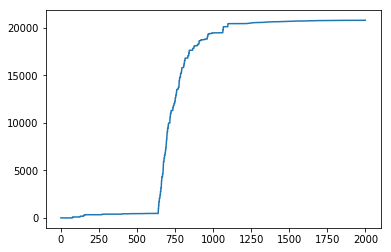

In [18]:
plt.plot(scores)
plt.show()

In [19]:
#the max Q-Value should be associated with the state-action pair (goal, goal)
#max Q-value is a the value of a $100 perpetuity associated with just staying in the goal state
print('Q-Value should converge to: ', 100/(1-discount_factor))
print('Q-Value in goal state after updates: ', Q[7,7])

Q-Value should converge to:  500.0000000000001
Q-Value in goal state after updates:  499.965971763308


In [20]:
#Testing
#See the recommended, quickest path to the goal(only reward) implied by the train Q-value assessments

current_state = np.random.randint(0, int(Q.shape[0]))

#initialize the list that will log the sequence of steps
steps = [current_state]

while current_state != 7:
    next_step_index = np.where(Q[current_state] == np.max(Q[current_state]))[0] 
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
        
    steps.append(next_step_index)
    current_state = next_step_index
    
print("The trained Q-Value Matrix says the best course of action is:")
print(steps)


The trained Q-Value Matrix says the best course of action is:
[16, 2, 7]


In [ ]:
#Q-learning without neural networks can only take you so far when the number of states in a system is large.

#For example, imagine training an agent to explore video game play...
#The number of video game states, where a "state" depends on, say, 4 consecutive video frames of 84x84 pixels is:

#=256^(4*84*84) >> atoms in the universe

#This assumes each pixel is grayscale with 256 possibile shades. It would be worse with RGB channels (256^3).

#And this is just the number of states.  
#You'd want to explore all possible actions from each state many times to better refine your Q-value estimates.